In [1]:
import pandas as pd

class PlayerRating:
    def __init__(self, standard_stats_path, passing_stats_path, goal_shot_stats_path, defensive_stats_path):
        self.standard_stats_path = standard_stats_path
        self.passing_stats_path = passing_stats_path
        self.goal_shot_stats_path = goal_shot_stats_path
        self.defensive_stats_path = defensive_stats_path
        self.df = None

    def load_and_merge_data(self):
        df = pd.read_csv(self.standard_stats_path, usecols=["Key", "League", "Team", "NonPenaltyGoalsPer90", "YelloCards", "ProgressiveCarries", "ProgressivePasses", "Min", "Goals", "Assists"])
        df1 = pd.read_csv(self.passing_stats_path, usecols=["Key", "Cmp%"])
        df2 = pd.read_csv(self.goal_shot_stats_path, usecols=["Key", "GCA90", "SCA90"])
        df3 = pd.read_csv(self.defensive_stats_path, usecols=["Key", "Total_Tackles", "Tackles_Won"])

        df = df.drop_duplicates(subset="Key")
        df1 = df1.drop_duplicates(subset="Key")
        df2 = df2.drop_duplicates(subset="Key")
        df3 = df3.drop_duplicates(subset="Key")

        df["Season"] = df["Key"].str[:9]
        df1["Season"] = df1["Key"].str[:9]
        df2["Season"] = df2["Key"].str[:9]
        df3["Season"] = df3["Key"].str[:9]

        df_merged = df.merge(df1, on=["Key", "Season"], how="left")\
                      .merge(df2, on=["Key", "Season"], how="left")\
                      .merge(df3, on=["Key", "Season"], how="left")

        self.df = df_merged

    def clean_and_standardize(self):
        cols = ["NonPenaltyGoalsPer90", "YelloCards", "ProgressiveCarries", "ProgressivePasses", "Min", "Goals", "Assists", "Cmp%", "GCA90", "SCA90", "Total_Tackles", "Tackles_Won"]
        for col in cols:
            self.df[col] = pd.to_numeric(self.df[col], errors="coerce")

        self.df["Tackle%"] = self.df["Tackles_Won"] / self.df["Total_Tackles"]
        self.df["Goals_90"] = self.df["Goals"] / 90
        self.df["Assists_90"] = self.df["Assists"] / 90
        self.df["Player"] = self.df["Key"].str[10:]

        for col in ["Goals", "Assists", "YelloCards", "ProgressiveCarries", "ProgressivePasses", "NonPenaltyGoalsPer90", "Cmp%", "SCA90", "GCA90", "Tackle%", "Goals_90", "Assists_90"]:
            self.df[f"{col}_z"] = (self.df[col] - self.df[col].mean()) / self.df[col].std()

    def calculate_player_ratings(self):
        self.df["PlayerRating"] = (
            0.1 * self.df["ProgressiveCarries_z"] + 
            0.1 * self.df["ProgressivePasses_z"] + 
            0.1 * self.df["NonPenaltyGoalsPer90_z"] + 
            0.15 * self.df["Cmp%_z"] + 
            0.05 * self.df["SCA90_z"] + 
            0.05 * self.df["GCA90_z"] + 
            0.10 * self.df["Tackle%_z"] + 
            0.2 * self.df["Goals_90_z"] + 
            0.15 * self.df["Assists_90_z"] +
            (-0.05) * self.df["YelloCards_z"]
        )

        league_map = {
            'EPL': 1, 'LaLiga': 0.99, 'Bundesliga': 0.95, 'SerieA': 0.95,
            'Ligue1': 0.93, 'EreDivisie': 0.88, 'PrimeiraLiga': 0.88
        }

        self.df['LeagueRating'] = self.df['League'].map(league_map)

        min_rating = self.df["PlayerRating"].min()
        max_rating = self.df["PlayerRating"].max()

        self.df["PlayerRating_1_10"] = 0.9764 + 9 * (self.df["PlayerRating"] - min_rating) / (max_rating - min_rating)
        self.df["PlayerRatingActual"] = self.df["PlayerRating_1_10"] * self.df["LeagueRating"]

    def get_top_players(self, top_n=10):
        return self.df[["Player", "PlayerRatingActual", "Season"]].sort_values(by="PlayerRatingActual", ascending=False).dropna().head(top_n)

if __name__ == "__main__":
    player_rating = PlayerRating(
        "./extracted_data/Cleaned_Standard_stats.csv", 
        "./extracted_data/Cleaned_Passing.csv",
        "./extracted_data/Cleaned_Goal_and_shot.csv",
        "./extracted_data/Cleaned_Defensive.csv"
    )

    player_rating.load_and_merge_data()
    player_rating.clean_and_standardize()
    player_rating.calculate_player_ratings()

    top_players = player_rating.get_top_players(20)
    print(top_players)



                  Player  PlayerRatingActual     Season
5178         lionelmessi            9.876636  2018-2019
9385         lionelmessi            9.743562  2019-2020
1132         lionelmessi            9.660050  2017-2018
13656        lionelmessi            8.960094  2020-2021
18805       kylianmbappe            8.835490  2021-2022
21558       mohamedsalah            8.827921  2022-2023
85          mohamedsalah            8.799135  2017-2018
18082       karimbenzema            8.782077  2021-2022
4135          edenhazard            8.676272  2018-2019
21456         bukayosaka            8.582569  2022-2023
16858       mohamedsalah            8.515735  2021-2022
23392       kylianmbappe            8.476479  2022-2023
8202       kevindebruyne            8.387495  2019-2020
21424      erlinghaaland            8.384518  2022-2023
24805         dusantadic            8.310295  2022-2023
13030  robertlewandowski            8.159431  2020-2021
7039          dusantadic            8.084707  20

KeyError: 'Interceptions_z'

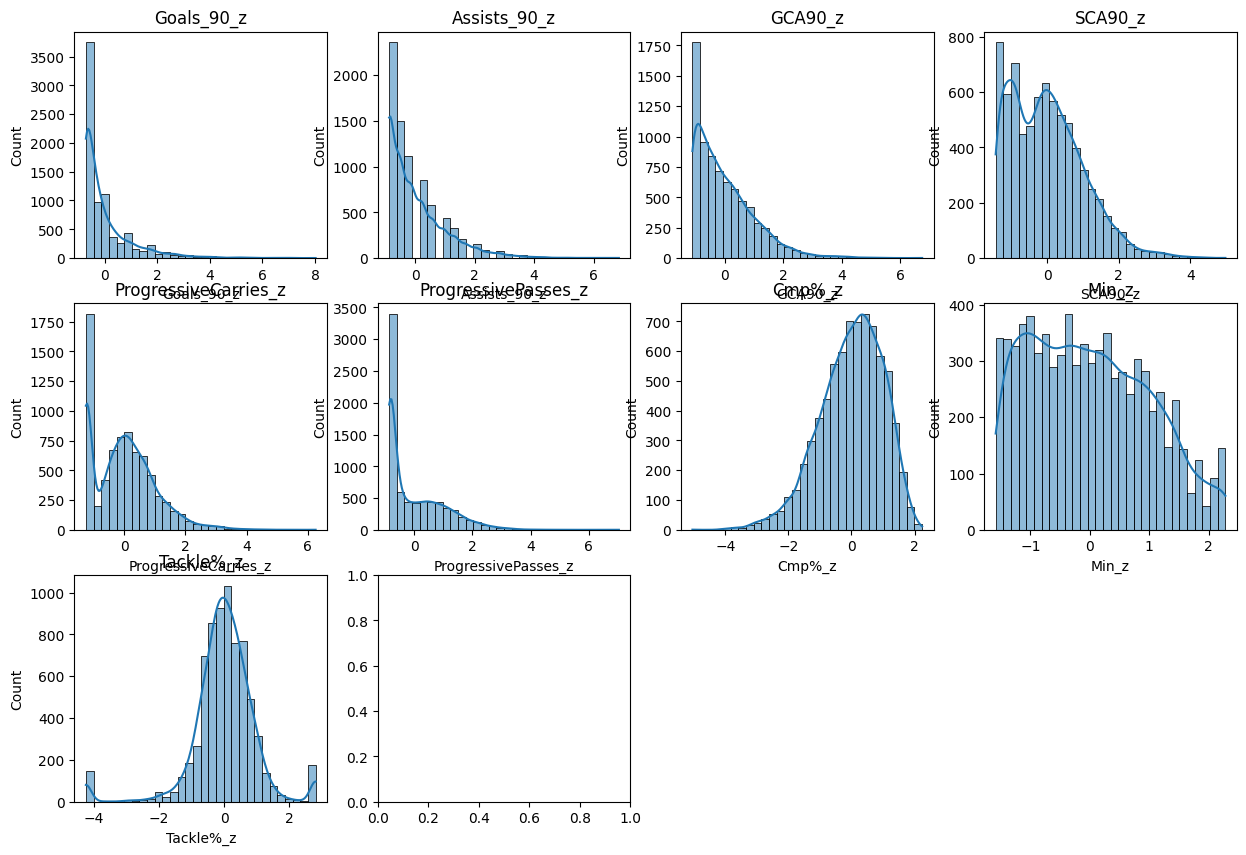

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ladda data, t.ex. från Players.csv
df = pd.read_csv("Players.csv")

# Lista över de variabler vi vill analysera
variables = ["Goals_90_z", "Assists_90_z", "GCA90_z", "SCA90_z", "ProgressiveCarries_z",
             "ProgressivePasses_z", "Cmp%_z", "Min_z", "Tackle%_z", "Interceptions_z",
             "PlayerRatingActual"]

# Skapa histogram för varje variabel
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables, 1):
    plt.subplot(3, 4, i)
    sns.histplot(df[var].dropna(), kde=True, bins=30)
    plt.title(var)  

plt.tight_layout()
plt.show()

# Skapa boxplots för att få en känsla för outliers
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=df[var].dropna())
    plt.title(var)

plt.tight_layout()
plt.show()

In [ ]:
df

In [7]:
import pandas as pd

df = pd.read_csv("Players.csv")

df["ProgressiveCarries_90"] = df["ProgressiveCarries"] / 90


df["ProgressivePasses_90"] = df["ProgressivePasses"] / 90

df.columns

Index(['League', 'Team', 'Min', 'Goals', 'Assists', 'YelloCards',
       'ProgressiveCarries', 'ProgressivePasses', 'NonPenaltyGoalsPer90',
       'Key', 'Season', 'Cmp%', 'SCA90', 'GCA90', 'Total_Tackles',
       'Tackles_Won', 'Tackles_Def_3rd', 'Tackles_mid_3rd', 'Interceptions',
       'Tackle%', 'Goals_90', 'Assists_90', 'Interceptions_90', 'Player',
       'NonPenaltyGoalsPer90_z', 'YelloCards_z', 'ProgressiveCarries_z',
       'ProgressivePasses_z', 'Min_z', 'Cmp%_z', 'GCA90_z', 'SCA90_z',
       'Total_Tackles_z', 'Tackles_Won_z', 'Interceptions_90_z',
       'Tackles_Def_3rd_z', 'Tackles_mid_3rd_z', 'Goals_90_z', 'Assists_90_z',
       'Tackle%_z', 'PlayerRating', 'LeagueRating', 'PlayerRating_1_10',
       'PlayerRatingActual', 'ProgressiveCarries_90', 'ProgressivePasses_90'],
      dtype='object')

In [ ]:
from streamlit_timeline import timeline

print(dir(timeline))